In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!ls "/content/drive/My Drive"
!pip install -q keras

'10foldRADIO_COVID .ipynb'   CT			    own
 Bangla_Iso		     edit.ipynb		   'RATNet(99.80).ipynb'
 CBAM_model.ipynb	     EYE		    Selected_model.ipynb
 CMATERdb		    'Getting started.pdf'   Untitled0.ipynb
'Colab Notebooks'	     ISI		    Untitled1.ipynb
 COVID			     OCR


In [2]:
# load in libaries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras import models
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras import optimizers
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
weight_decay = 1e-6
from keras.regularizers import l2
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.layers.normalization import BatchNormalization
import keras
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv2D, Activation, MaxPool2D, Dropout, Dense, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Average, Dropout
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import l2
from six.moves import cPickle as pickle
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

Using TensorFlow backend.


In [36]:
# Lets load in the data
Xtrain = np.load('/content/drive/My Drive/CT/X.npy')
Ytrain = np.load('/content/drive/My Drive/CT/Y.npy')

print('X shape : {}  Y shape: {}'.format(Xtrain.shape, Ytrain.shape))
#print('X shape : {}  Y shape: {}'.format(Xtest.shape, Ytest.shape))

X shape : (2482, 64, 64, 3)  Y shape: (2482, 2)


In [27]:
#create a data generator using Keras image preprocessing
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.10,  
        height_shift_range=0.10,  
        horizontal_flip=False, 
        vertical_flip=False)

In [37]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xtrain, Ytrain, test_size=.20,shuffle=True,random_state=42)
#Xtrain, Xvalid, Ytrain, yvalid = train_test_split(Xtrain, Ytrain, test_size=.10)
# add another axis representing grey-scale
#Xvalid,Xtest, yvalid,Ytest = train_test_split(Xvalid,yvalid, test_size=0.66)
#Xtrain = Xtrain[:,:,:,np.newaxis]
#Xvalid = Xvalid[:,:,:,np.newaxis]
#test = Xtest[:,:,:,np.newaxis]
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)
#print(Xvalid.shape)
#print(yvalid.shape)

(1985, 64, 64, 3)
(1985, 2)
(497, 64, 64, 3)
(497, 2)


In [29]:
datagen.fit(Xtrain)
#val_datagen.fit(Xvalid)

In [10]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Lambda


def residual_block(input, input_channels=None, output_channels=None, kernel_size=(3, 3), stride=1):
    """
    full pre-activation residual block
    https://arxiv.org/pdf/1603.05027.pdf
    """
    if output_channels is None:
        output_channels = input.get_shape()[-1]
    if input_channels is None:
        input_channels = output_channels // 4

    strides = (stride, stride)
    x = Conv2D(input_channels, (1, 1))(input)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(input_channels, kernel_size, padding='same', strides=stride)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)


    x = Conv2D(output_channels, (1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)



    if input_channels != output_channels or stride != 1:
        input = Conv2D(output_channels, (1, 1), padding='same', strides=strides)(input)

    x = Add()([x, input])
    return x


def attention_block(input, input_channels=None, output_channels=None, encoder_depth=1):
    """
    attention block
    https://arxiv.org/abs/1704.06904
    """

    p = 1
    t = 1
    r = 1

    if input_channels is None:
        input_channels = input.get_shape()[-1]
    if output_channels is None:
        output_channels = input_channels

    # First Residual Block
    for i in range(p):
        input = residual_block(input)

    # Trunc Branch
    output_trunk = input
    for i in range(t):
        output_trunk = residual_block(output_trunk)

    # Soft Mask Branch

    ## encoder
    ### first down sampling
    output_soft_mask = MaxPool2D(padding='same')(input)  # 32x32
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)

    skip_connections = []
    for i in range(encoder_depth - 1):

        ## skip connections
        output_skip_connection = residual_block(output_soft_mask)
        skip_connections.append(output_skip_connection)
        # print ('skip shape:', output_skip_connection.get_shape())

        ## down sampling
        output_soft_mask = MaxPool2D(padding='same')(output_soft_mask)
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)

            ## decoder
    skip_connections = list(reversed(skip_connections))
    for i in range(encoder_depth - 1):
        ## upsampling
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)
        output_soft_mask = UpSampling2D()(output_soft_mask)
        ## skip connections
        output_soft_mask = Add()([output_soft_mask, skip_connections[i]])

    ### last upsampling
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)
    output_soft_mask = UpSampling2D()(output_soft_mask)

    ## Output
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Activation('sigmoid')(output_soft_mask)

    # Attention: (1 + output_soft_mask) * output_trunk
    output = Lambda(lambda x: x + 1)(output_soft_mask)
    output = Multiply()([output, output_trunk])  #

    # Last Residual Block
    for i in range(p):
        output = residual_block(output)

    return output

In [11]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Model
from keras.regularizers import l2

def Covid(shape=(64, 64, 3), n_channels=32, n_classes=2):
    """
    Attention-56 ResNet for Cifar10 Dataset
    https://arxiv.org/abs/1704.06904
    """
    input_ = Input(shape=shape)
    x = Conv2D(n_channels, (3, 3), padding='same')(input_)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)  # 16x16

    x = residual_block(x, input_channels=64, output_channels=128)
    x = attention_block(x, encoder_depth=1)

    x = residual_block(x, input_channels=128, output_channels=256, stride=2)  # 8x8
    x = attention_block(x, encoder_depth=1)

   # x = residual_block(x, input_channels=256, output_channels=256, stride=2)  # 4x4
    #x = attention_block(x, encoder_depth=1)

  #  x = residual_block(x, input_channels=512, output_channels=1024)
   # x = residual_block(x, input_channels=1024, output_channels=1024)
   # x = residual_block(x, input_channels=1024, output_channels=1024)

    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # 1x1
    x = Flatten()(x)
    x=Dense(256,activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input_, output)
    return model

In [ ]:

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
#from albumentations import *
from skimage.transform import resize

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import load_model, Model
import tensorflow as tf
from keras import backend as K
modell = Covid()
modell.summary()

from keras.optimizers import Adam
def compile_and_train(model, num_epochs):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkPoint = ModelCheckpoint(filepath='/content/drive/My Drive/CT/Test/Model_weights.hdf5', verbose=1, save_best_only=True,monitor='val_accuracy',mode='max')
    earlystopping = EarlyStopping(monitor='val_loss',
                              patience=200,
                              verbose=1,
                              mode='min',
                              restore_best_weights=True)
    lr_reduce = ReduceLROnPlateau(monitor='val_loss',mode='min', factor=0.75, epsilon=0.0001, patience=6, verbose=1)    
    history = model.fit_generator(datagen.flow(Xtrain, Ytrain, batch_size=128),
                 epochs=num_epochs,verbose=2,
                 steps_per_epoch=64,
                 shuffle=True,
                 callbacks=[checkPoint,lr_reduce,earlystopping],
                 validation_data=(Xtest, Ytest)
                  )

    #model.save_weights('/content/drive/My Drive/CMATERdb/iso_32/Test/ISo_32.hdf5')
    model.save('/content/drive/My Drive/CT/CT_COVID.h5')
    return history
                       
s1=compile_and_train(modell,200)
score=s1.model.evaluate(Xtest, Ytest)
print('Loss: {:.4f}  Accuaracy: {:.4}%'.format(score[0],score[1]*100))



In [38]:
# Save and load model_weights

from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/CT/Model/Covid_model.h5')
score=model.evaluate(Xtest, Ytest,batch_size=128)
print('Loss: {:.4f}  Accuaracy: {:.4}%'.format(score[0],score[1]*100))

4/4 [==============================] - 0s 67ms/step - loss: 0.0066 - accuracy: 0.9980
Loss: 0.0066  Accuaracy: 99.8%


accuracy:  0.9979879275653923
f1:  0.9980657640232108
recall:  1.0
precision:  0.9961389961389961
auc:  0.997907949790795
              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00       239
   Non_COVID       1.00      1.00      1.00       258

    accuracy                           1.00       497
   macro avg       1.00      1.00      1.00       497
weighted avg       1.00      1.00      1.00       497



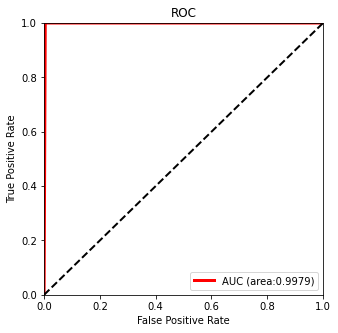

In [39]:
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,roc_curve,accuracy_score,classification_report


y_pred = model.predict(Xtest)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(Ytest, axis=1)

#accuracy
accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

#f1_score
f1 = f1_score(y_true, y_pred,average='binary')
print('f1: ', f1)

# recall_score
recall = recall_score(y_true, y_pred, average='binary')
print('recall: ', recall)

#precision_score
precision = precision_score(y_true, y_pred, average='binary')
print('precision: ', precision) 

auc = roc_auc_score(y_true, y_pred)
print('auc: ', auc)

print(classification_report(y_true, y_pred, target_names= ['COVID','Non_COVID']))



fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,color='red',linewidth=3,label='AUC (area:%0.4f)'%auc)  
plt.plot([0, 1], [0, 1], color='black',linewidth=2, linestyle='--')  
plt.xlim([0, 1])  
plt.ylim([0, 1])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('ROC')  
plt.legend(loc="lower right")      
plt.show()

In [ ]:
from sklearn.metrics import classification_report,precision_score,recall_score,accuracy_score,f1_score
yhat_probs = s1.model.predict(Xtest)
yhat_classes = np.argmax(yhat_probs, axis=1)
Y_real = np.argmax(Ytest, axis=1)
print("recall : ",recall_score(Y_real,yhat_classes, average='macro'))
print("precision : ", precision_score(Y_real, yhat_classes, average='macro'))
print("f1 score: ",f1_score(Y_real, yhat_classes , average='macro'))

print(classification_report(Y_real, yhat_classes))

recall :  0.9029796511627908
precision :  0.8943812233285917
f1 score:  0.8928571428571428
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.97      0.84      0.90        43

    accuracy                           0.89        75
   macro avg       0.89      0.90      0.89        75
weighted avg       0.91      0.89      0.89        75

